In [1]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
from scipy import signal
import os
import pandas as pd
from scipy.signal import stft
from math import prod
# from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from math import e
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD, Adam
from keras.utils.np_utils import to_categorical
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder
from urllib.request import urlopen, urlretrieve

# import matplotlib.pyplot as plt
%matplotlib inline

2022-06-02 16:50:47.862602: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-02 16:50:47.866404: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-02 16:50:47.866417: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def butter_bandpass(data, lowcut, highcut, fs=200, order=4):
    nyq = fs * 0.5
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='bandpass')
    return signal.filtfilt(b, a, data)


def butter_lowpass(data, lowcut, fs=200, order=4):
    nyq = fs * 0.5
    low = lowcut / nyq
    b, a = signal.butter(order, low, btype='lowpass')
    return signal.filtfilt(b, a, data)


def butter_highpass(data, highcut, fs=200, order=4):
    nyq = fs * 0.5
    high = highcut / nyq
    b, a = signal.butter(order, high, btype='highpass')
    return signal.filtfilt(b, a, data)


def butter_notch(data, cutoff, var=1, fs=200, order=4):
    nyq = fs * 0.5
    low = (cutoff - var) / nyq
    high = (cutoff + var) / nyq
    b, a = signal.iirfilter(order, [low, high], btype='bandstop', ftype="butter")
    return signal.filtfilt(b, a, data)

In [3]:
def filtros(data):
    data_filtered = butter_notch(data, 60)
    data_filtered = butter_highpass(data_filtered, 5)
    data_filtered = butter_lowpass(data_filtered, 50)
    return data_filtered

In [4]:
dir = './datasets/topicos_cc'
arquivos = os.listdir(dir)
arq_numpy = [f for f in arquivos if f.endswith(".npy") and f.startswith('p2')]
participantes = {}
for i in arq_numpy:
    nome = i.split('_')
    trial = np.load(dir+'/'+i)
    for m in range(0,8):
        if participantes.get(f'participante_{nome[0]}',0) == 0:
            participantes[f'participante_{nome[0]}'] = {}
        if participantes[f'participante_{nome[0]}'].get(f'trial_{nome[1]}',0) == 0:
            participantes[f'participante_{nome[0]}'][f'trial_{nome[1]}'] = {}
        dados = trial[m, :, :].swapaxes(0,1)
        participantes[f'participante_{nome[0]}'][f'trial_{nome[1]}'][f'movimento_{m+1}'] = filtros(dados)

v = list()
for i in arq_numpy:
    trial = np.load(dir+'/'+i)
    v.append(trial[:, :, :].swapaxes(1,2))    

arr = np.vstack((v[0], v[1], v[2]))

print(arr.shape)

(24, 4, 1600)


In [5]:
step = 11.8
segment = 128
data = arr
# .get_data()
print('', data.shape)

n_win = int((data.shape[-1] - segment) / step) + 1
ids = np.arange(n_win) * int(step)

# Janelas do dado no dominio do tempo
chunks_time = np.array([data[:,:,k:(k + segment)] for k in ids]).transpose(1, 2, 0, 3)

# Janelas do dado no domínio da frequência
_, _, chunks_freq = stft(data, fs=200, nperseg=128, noverlap=115)
chunks_freq = np.swapaxes(chunks_freq, 2, 3)

print('Formato (shape) dos dados depois da divisão de janelas')
print(f'Dominio do tempo: {chunks_time.shape} - (classes, ensaios, canais, janelas, linhas)')
print(f'Dominio da frequência:  {chunks_freq.shape} - (classes, ensaios, canais, janelas, linhas)')

 (24, 4, 1600)
Formato (shape) dos dados depois da divisão de janelas
Dominio do tempo: (24, 4, 125, 128) - (classes, ensaios, canais, janelas, linhas)
Dominio da frequência:  (24, 4, 125, 65) - (classes, ensaios, canais, janelas, linhas)


In [6]:
# funções auxiliares
def PSD(w):
    ''' definição da função PSD para o sinal no domínio da frequência '''
    return np.abs(w) ** 2


# funções de extração de características

def var(x):
    return np.sum(x ** 2, axis=-1) / (np.prod(x.shape[:-1]) - 1)

def rms(x):
    return np.sqrt(np.sum(np.abs(x) ** 2, axis=-1) / (np.prod(x.shape[:-1])))

def wamp(x):
    limiar = np.abs(np.diff(x))
    return np.sum(limiar > 0.0001, axis=-1)

def wl(x):
    return np.sum(np.abs(np.diff(x)), axis=-1)

# def zc(x):
#     trs = 0.0001
 
#     f = [1 if i*j <= 0 else 0 for i,j in zip(x[:,:,:,:-1], x[:,:,:,1:])]
    
#     return np.sum(f)


def getzc(data, th):
    t = len(data)
    soma = 0
    for i in range(t-1):
        res = (data[i]*data[i+1])
        res2 = np.abs(data[i]-data[i+1])
        if (res<0 and res2 > th):
            soma +=1
    return soma

def zc(data):
    f=[]
    x,y,z = data.shape[:3]
    for i in range(x):
        l = []
        for j in range(y):
            li = []
            for k in range(z):
                li.append(getzc(data[i][j][k], 0.0001))
            l.append(li.copy())
        f.append(l.copy())

    return np.array(f)

def fmd(w):
    return np.sum(PSD(w), axis=-1) / 2

def mmdf(w):
    return np.sum(np.abs(w), axis=-1) / 2


def fmn(w):
    sample_rate = 200
    f = (w * sample_rate)/(2*len(w))
    return np.sum(np.abs(f*PSD(w)), axis=-1)/np.sum(PSD(w), axis=-1)

def mmnf(w):
    sample_rate = 200
    f = (w * sample_rate)/(2*len(w))
    return np.sum(np.abs(f*np.abs(w)), axis=-1)/np.sum(np.abs(w), axis=-1)


def logDec(data):
    N = np.prod(data.shape)
    return e ** (np.sum(np.log10(np.abs(data)), axis=-1))/N


def iemg(x):
    return np.sum(np.abs(x), axis=-1)

def dasdv(x):
    return np.sqrt(np.sum(np.diff(x)**2, axis=-1)/(np.prod(x.shape[:-1]) - 1))

def tm(x,n):
    return np.abs(np.sum(x**n , axis=-1)/np.prod(x.shape[:-1]))

In [7]:
final_data = list()
final_data.append(var(chunks_time))
final_data.append(rms(chunks_time))
final_data.append(fmd(chunks_freq))
final_data.append(mmdf(chunks_freq))
final_data.append(logDec(chunks_time))
final_data.append(wamp(chunks_time))
final_data.append(wl(chunks_time))
final_data.append(zc(chunks_time))
final_data.append(fmn(chunks_freq))
final_data.append(mmnf(chunks_freq))
final_data.append(iemg(chunks_time))
final_data.append(dasdv(chunks_time))
print(iemg(chunks_time).shape)
for n in range(3,6):
    final_data.append(tm(chunks_time, n))



f, Pxx_den = signal.welch(data, fs=200, nperseg=248, noverlap=223)
# print(f.shape)
# print(Pxx_den.shape)
final_data.append(Pxx_den)

final = np.array(final_data)
final.shape



# (24,                  4,      125,    65) - 
# (classes + ensaios, canais, janelas, linhas)

(24, 4, 125)


(16, 24, 4, 125)

In [8]:
X = final.transpose(1,3,2,0)
X = X.reshape(X.shape[0]*X.shape[1], X.shape[2]*X.shape[3])
X.shape

(3000, 64)

In [9]:
y = [[i] * int(X.shape[0] / 8) for i in range(8)]
y = np.array(y).flatten()
print('Shape dos rótulos:', y.shape)

Shape dos rótulos: (3000,)


In [10]:
# # Dividindo em conjuntos de treino (80%) e teste (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3)

# # treino: 80% dos 80% de treino. teste: 20% dos 80% de treino.

# --------- split validacao
# ---------- separar trials p treino e teste
# --------- kfold

In [11]:
# X_train.shape, X_val.shape, y_train.shape, y_val.shape

In [12]:
scaler = StandardScaler()
scaler.fit(X_train)
# scaler.fit(X)


# print(type(X_train))
# print(type(scaler.transform(X_train)))

X_train = scaler.transform(X_train)
# X = scaler.transform(X)
X_test = scaler.transform(X_test)

X_train = np.nan_to_num(X_train)
X_test = np.nan_to_num(X_test)

/home/luisotavio/.local/lib/python3.8/site-packages/sklearn/utils/extmath.py:1014: RuntimeWarning: overflow encountered in square
  temp **= 2
/home/luisotavio/.local/lib/python3.8/site-packages/sklearn/utils/extmath.py:1020: RuntimeWarning: overflow encountered in square
  new_unnormalized_variance -= correction ** 2 / new_sample_count
/home/luisotavio/.local/lib/python3.8/site-packages/sklearn/utils/extmath.py:1020: RuntimeWarning: invalid value encountered in subtract
  new_unnormalized_variance -= correction ** 2 / new_sample_count
/home/luisotavio/.local/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:80: RuntimeWarning: overflow encountered in square
  upper_bound = n_samples * eps * var + (n_samples * mean * eps) ** 2


In [13]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.3, shuffle=True)

In [14]:
def plot_history(h):
    loss_list = [s for s in h.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in h.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in h.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in h.history.keys() if 'acc' in s and 'val' in s]
    if len(loss_list) == 0:
        print('Custo não está presente no histórico')
        return
    epochs = range(1, len(history.history[loss_list[0]]) + 1)
    # Custo
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, h.history[l], 'b',
                 label='Custo [treinamento] (' + str(str(format(
                    h.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, h.history[l], 'g',
                 label='Custo [validação] (' + str(str(format(
                    h.history[l][-1],'.5f'))+')'))
    plt.title('Custo')
    plt.xlabel('Épocas')
    plt.ylabel('Custo')
    plt.legend()
    # Acurácia
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, h.history[l], 'b',
                 label='Acurácia [treinamento] (' + str(format(
                    h.history[l][-1],'.5f'))+')')
    for l in val_acc_list:
        plt.plot(epochs, h.history[l], 'g',
                 label='Acurácia [validação] (' + str(format(
                    h.history[l][-1],'.5f'))+')')
    plt.title('Acurácia')
    plt.xlabel('Épocas')
    plt.ylabel('Acurácia')
    plt.legend()
    plt.show()

Epoch 1/100


/home/luisotavio/.local/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/home/luisotavio/.local/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 2ms/step - loss: 1.9870 - accuracy: 0.3673 - val_loss: 1.6065 - val_accuracy: 0.5270
Epoch 2/100
98/98 [==============================] - 0s 1ms/step - loss: 1.4426 - accuracy: 0.5905 - val_loss: 1.3196 - val_accuracy: 0.6381
Epoch 3/100
98/98 [==============================] - 0s 2ms/step - loss: 1.2510 - accuracy: 0.6463 - val_loss: 1.2261 - val_accuracy: 0.6540
Epoch 4/100
98/98 [==============================] - 0s 1ms/step - loss: 1.1482 - accuracy: 0.7095 - val_loss: 1.1330 - val_accuracy: 0.6921
Epoch 5/100
98/98 [==============================] - 0s 1ms/step - loss: 1.0956 - accuracy: 0.7041 - val_loss: 1.1169 - val_accuracy: 0.7032
Epoch 6/100
98/98 [==============================] - 0s 1ms/step - loss: 1.0532 - accuracy: 0.7163 - val_loss: 1.0598 - val_accuracy: 0.7111
Epoch 7/100
98/98 [==============================] - 0s 1ms/step - loss: 1.0214 - accuracy: 0.7469 - val_loss: 1.0219 - val_accuracy: 0.7635
Epoch 8/100
98/98 [======

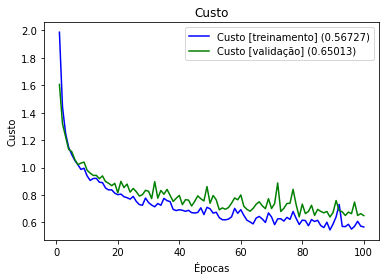

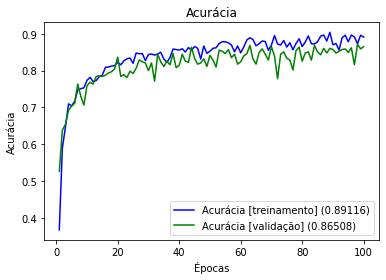

29/29 [==============================] - 0s 662us/step
Acurácia: 86.89%
Matriz de confusão:
[[ 97   3   0   0   0   0   1   4]
 [  5  85   0   0   0   5  10   2]
 [  2   2  87   3   1   1   0  14]
 [  1   0   1 113   2   2   0   2]
 [  0   0   9   2  94   6   0   2]
 [  5   4   0   0   0 109   4   1]
 [  0   5   0   0   0   0 112   0]
 [  0  15   3   1   0   0   0  85]]

              precision    recall  f1-score   support

           0    0.88182   0.92381   0.90233       105
           1    0.74561   0.79439   0.76923       107
           2    0.87000   0.79091   0.82857       110
           3    0.94958   0.93388   0.94167       121
           4    0.96907   0.83186   0.89524       113
           5    0.88618   0.88618   0.88618       123
           6    0.88189   0.95726   0.91803       117
           7    0.77273   0.81731   0.79439       104

    accuracy                        0.86889       900
   macro avg    0.86961   0.86695   0.86695       900
weighted avg    0.87225   0.86

In [25]:
# definição de uma fração do regularizador
l = 0.01

# desenvolvimento do modelo Keras para uma MLP
model = Sequential()
model.add(Dense(20, activation='relu', input_dim=64,
                kernel_regularizer=regularizers.l2(l)))
# Aplicação de um dropout (caso necessário)
# model.add(Dropout(0.5))
model.add(Dense(10, activation='relu',
                kernel_regularizer=regularizers.l2(l)))
# Aplicação de um dropout (caso necessário)
# model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))

# Aplicação de um modelo de descida de gradiente utilizando o Stocastic Gradient Descendent (SGD)
sgd = SGD(lr=0.05, momentum=0.0)
# Função de otimização da rede: ADAM
adam = Adam(lr=0.005, beta_1=0.9, beta_2=0.999)
# Função de custo baseada em dados originalmente categóricos


model.compile(loss='sparse_categorical_crossentropy', optimizer=adam,
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=100, batch_size=15,
                    validation_data=(X_val, y_val))
plot_history(history)
# score = model.predict_classes(X_test)
predict_x=model.predict(X_test) 
score=np.argmax(predict_x,axis=1)
# y_true = [np.where(x == 1)[0] for x in y_test]
y_true = y_test
print('\n\nAcurácia: %0.2f%%' % (accuracy_score(y_true, score) * 100))
print('Matriz de confusão:')
print(confusion_matrix(y_true, score))
print()
print(classification_report(y_true, score, digits=5))